<a href="https://colab.research.google.com/github/kulbir-ahluwalia/CMSC818B_MiniProject_2/blob/main/python/pm_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Get the required python files
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/custom_algorithms.py


--2020-12-04 04:35:59--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5622 (5.5K) [text/plain]
Saving to: ‘actors.py’

actors.py           100%[===================>]   5.49K  --.-KB/s    in 0s      

2020-12-04 04:35:59 (68.1 MB/s) - ‘actors.py’ saved [5622/5622]

--2020-12-04 04:35:59--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6874 (6.7K) [tex

In [ ]:
!pip install pygame

     |████████████████████████████████| 11.5MB 5.1MB/s 


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys
import pygame


# set SDL to use the dummy NULL video driver, 
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.0.0 (SDL 2.0.12, python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
## Import classes for elements and visualization
from actors import Player, Obstacle, Drone
from pm_env import Canvas, process_into_image, process_img, get_obstacles, get_droneview, update_all, process_screen

### Defining the environement

In [ ]:
## Canvas is the grid we are going to use
canvas = Canvas(300,300)

## Create the robots
playerList = []
playerList.append(Player(pos=[20, 10], color='g', size=10))
playerList.append(Player(pos=[0, 260], color='g', size=10))
playerList.append(Player(pos=[200, 10], color='g', size=10))
playerList.append(Player(pos=[250, 200], color='g', size=10))
# playerList.append(Player(pos=[200, 300], color='g', size=10))
# playerList.append(Player(pos=[400, 400], color='g', size=10))

## Create teh robots at random locations
n_obj = 20 # number of objects
obstacleList = []
# obstacleList.append(Obstacle(pos=[60, 60], size=[10,15]))
# obstacleList.append(Obstacle(pos=[60, 60],size=[20,10]))
r_coords = np.random.randint(0, canvas.height, (n_obj)) # random rows
c_coords = np.random.randint(0, canvas.width, (n_obj)) # random columns
# Width and height would be chosen from 10,15,20,25,30 randomly
for i in range(len(r_coords)):
    obstacleList.append(Obstacle(pos=[r_coords[i], c_coords[i]], 
                                 size=[np.random.choice([10,15,20,25,30]),np.random.choice([10,15,20,25,30])]))


### Add drone to the environememnt
droneList = []
droneList.append(Drone(pos=[150,150], color='b',  size=100))

### Algorithms for testing

In [ ]:
# pygame.init()

## Step size. How many grids would the robot move at each step
step_size = playerList[0].size

## the dictionary defniing how many to update the location
move_dict = {
    'left' : np.array([0, -step_size]),
    'up' : np.array([-step_size,0]),
    'right' : np.array([0, step_size]),
    'down' : np.array([step_size,0])
}


    


#### Lawnmower algorithm with *hover over buildings*

In [ ]:
## Order of moves for anti-clockwise movement
anti_clock_order_dict = {'up' : 0,
                    'right': 1,
                    'down' : 2,
                    'left': 3}
anti_clock_order = ['down', 'right', 'up', 'left']

## Function to check if a location is valid (within grid)
def is_valid(pos, limits):
    if ((pos[0] < 0) or (pos[1] < 0) or (pos[0] >= limits[0]) or (pos[1] >= limits[1])):
        return False
    else:
        return True

## The lawnmower algorithm
def lawn_mover(player, data_img):
    pos = player.pos  # Get players location
    obstacle = (data_img[:,:,0] > 0).astype(int) # get grid indicating where objects are
    covered = (data_img[:,:,1] > 0).astype(int) # get grid indicating which areas have been covered
    # covered[data_img[:,:,1] == 255] = 0

    # if the last action is not recorded, move to left or right as per the row
    if player.prev_action == None:
        player.prev_action = ['right', 'left'][pos[1]%2]
    

    ####
    ## Iterate over each direction, till yu find a valid orientation to move
    for i in range(4):
        player.prev_action = anti_clock_order[(anti_clock_order_dict[player.prev_action]+i) %4]
        move = move_dict[player.prev_action]
        print('CHECK: ', pos, move, player.prev_action)
        temp_pos = pos + move
        if not is_valid(temp_pos, data_img.shape[:2]):
            continue
        else:
            if (covered[temp_pos[0], temp_pos[1]] == 1):# or (obstacle[temp_pos[0], temp_pos[1]] == 1):
            # if (obstacle[temp_pos[0], temp_pos[1]] == 1):
                continue
            else:
                break
    return temp_pos



#### Greedy movement

In [ ]:
## Greedy algorithm (distributed)
def greedy_algorithm(player, data_img):
    pos = player.pos #get player location
    obstacle = data_img[:,:,2].astype(int) # get grid indicating where objects are
    covered = (data_img[:,:,1]).astype(int) # get grid indicating which areas have been covered and how much latency is there
    # covered[data_img[:,:,1] == 255] = 0
    cost_grid = obstacle*10 + covered # give high cost to obstacles

    # if the last action is not recorded, move to left or right as per the row
    action_list = ['right', 'down', 'left', 'up']
    if player.prev_action == None:
        player.prev_action = ['right', 'left'][pos[0]%2]


    #######
    ## Looks into future move for all 4 directions, move whereever robot would have least cost
    temp_action_list = []
    temp_cost_list = []
    for i in range(4):
        new_action = action_list[ (action_list.index(player.prev_action) + i) % 4 ]
        move = move_dict[ new_action ]
        
        temp_pos = pos + move
        # print('CHECK: ', pos, temp_pos, new_action)
        if not is_valid(temp_pos, data_img.shape[:2]):
            # print('NOT Valid: ', pos, temp_pos)
            temp_action_list.append(new_action)
            temp_cost_list.append(50000)
            # continue
        else:
            # if (covered[temp_pos[0], temp_pos[1]] == 1) or (obstacle[temp_pos[0], temp_pos[1]] == 1):
            temp_action_list.append(new_action)
            temp_cost = np.sum(cost_grid[max(0,temp_pos[0]-player.size):min(temp_pos[0]+player.size, data_img.shape[0]), 
                                         max(0, temp_pos[1]-player.size): min(temp_pos[1]+player.size,data_img.shape[1])])
            temp_cost_list.append(temp_cost)

                # print('OCCUPIED: ', covered[temp_pos[0], temp_pos[1]], obstacle[temp_pos[0], temp_pos[1]] )
            #     continue
            # else:
            #     break

    # print('Costs: ', temp_cost_list)
    # print('Actions: ', temp_action_list)

    # Choose next action based on where the cost would be least
    new_action = temp_action_list[np.argmin(temp_cost_list)]
    temp_pos = pos + move_dict[ new_action ]

    # update last action
    player.prev_action = new_action
    
    # if teh move is not valid, do not move
    if not is_valid(temp_pos, data_img.shape[:2]):
        temp_pos = pos
        
    return temp_pos


In [ ]:
### Envoronemtn image as a numpy array
data_img = np.zeros(canvas.grid.shape+(3,))
# data_img = init_env(canvas, playerList, obstacleList, droneList)
### Coverage information
coverage = np.zeros(canvas.grid.shape, dtype=np.uint8)
#### Drone Map
drone_map = np.zeros(canvas.grid.shape+(3,), dtype=np.uint8)
## Run for 300 iterations
latency_factor = 2
for i in range(300):

    ### Get next location for each robot
    for player in playerList:
        # Form 1: use position dircetly
        # player.pos = (x,y)

        # Form 2: use move function with size and canvas
        # player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, canvas)

        # player.pos = lawn_mover(player, data_img)
        player.pos = greedy_algorithm(player, data_img)
        # player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, canvas)

    ### Get next location for the drone
    for drone in droneList:
         drone.move(np.random.choice(['up', 'down', 'left', 'right']), drone.size//10, canvas)   

    update_all(canvas, playerList, obstacleList, droneList) 


    covergae, data_img = process_screen(my_coverage=coverage, my_canvas=canvas)
    obstacle_map = get_obstacles(data_img)
    
    # drone_map = get_droneview(drone_map, data_img, latency_factor)
    drone_map = get_droneview(drone_map, data_img, latency_factor, droneList)
    #Display image, clear cell every 0.5 seconds
    #convert image so it can be displayed in OpenCV
    ## UNCOMMENT IN CASE OF ISSUE
    # view = pygame.surfarray.array3d(canvas.screen)
    
    #  convert from (width, height, channel) to (height, width, channel)
    ## UNCOMMENT  NEXT 2 LINES IN CASE OF ERROR
    # view = view.transpose([1, 0, 2])
    # img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

    # cv2_imshow(data_img) #img_bgr[yv, xv])
    print('\t\t Environment \t\t\t Drone View ')
    cv2_imshow(np.hstack([data_img, drone_map]))
    print('\t\t Coverage \t\t\t Obstacles ')
    cv2_imshow(np.hstack([coverage, 255*obstacle_map]))
    

    ## Wait 0.1 second before running next iteration
    time.sleep(0.1)
    output.clear()

    # if i == 3:
    #     break



## Gym like Env

In [ ]:
## Get the required python files
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/custom_algorithms.py


--2020-12-05 15:30:41--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5622 (5.5K) [text/plain]
Saving to: ‘actors.py’

actors.py           100%[===================>]   5.49K  --.-KB/s    in 0s      

2020-12-05 15:30:41 (72.5 MB/s) - ‘actors.py’ saved [5622/5622]

--2020-12-05 15:30:41--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6874 (6.7K) [

In [ ]:
!pip install gym
!pip install pygame

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import gym
from gym import spaces

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys
import pygame


# set SDL to use the dummy NULL video driver, 
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.0.0 (SDL 2.0.12, python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
## Import classes for elements and visualization
from actors import Player, Obstacle, Drone
from pm_env import Canvas, process_into_image, process_img, get_obstacles, get_droneview, update_all, process_screen

### Greedy Algorithm

In [ ]:
# pygame.init()

## Step size. How many grids would the robot move at each step
step_size = 10

## the dictionary defniing how many to update the location
move_dict = {
    'left' : np.array([0, -step_size]),
    'up' : np.array([-step_size,0]),
    'right' : np.array([0, step_size]),
    'down' : np.array([step_size,0])
}

## Function to check if a location is valid (within grid)
def is_valid(pos, limits):
    if ((pos[0] < 0) or (pos[1] < 0) or (pos[0] >= limits[0]) or (pos[1] >= limits[1])):
        return False
    else:
        return True

## Greedy algorithm (distributed)
def greedy_algorithm(player, data_img):
    pos = player.pos #get player location
    obstacle = data_img[:,:,2].astype(int) # get grid indicating where objects are
    covered = (data_img[:,:,1]).astype(int) # get grid indicating which areas have been covered and how much latency is there
    # covered[data_img[:,:,1] == 255] = 0
    cost_grid = obstacle*10 + covered # give high cost to obstacles

    # if the last action is not recorded, move to left or right as per the row
    action_list = ['right', 'down', 'left', 'up']
    if player.prev_action == None:
        player.prev_action = ['right', 'left'][pos[0]%2]


    #######
    ## Looks into future move for all 4 directions, move whereever robot would have least cost
    temp_action_list = []
    temp_cost_list = []
    for i in range(4):
        new_action = action_list[ (action_list.index(player.prev_action) + i) % 4 ]
        move = move_dict[ new_action ]
        
        temp_pos = pos + move
        # print('CHECK: ', pos, temp_pos, new_action)
        if not is_valid(temp_pos, data_img.shape[:2]):
            # print('NOT Valid: ', pos, temp_pos)
            temp_action_list.append(new_action)
            temp_cost_list.append(50000)
            # continue
        else:
            # if (covered[temp_pos[0], temp_pos[1]] == 1) or (obstacle[temp_pos[0], temp_pos[1]] == 1):
            temp_action_list.append(new_action)
            temp_cost = np.sum(cost_grid[max(0,temp_pos[0]-player.size):min(temp_pos[0]+player.size, data_img.shape[0]), 
                                         max(0, temp_pos[1]-player.size): min(temp_pos[1]+player.size,data_img.shape[1])])
            temp_cost_list.append(temp_cost)


    # Choose next action based on where the cost would be least
    new_action = temp_action_list[np.argmin(temp_cost_list)]
    temp_pos = pos + move_dict[ new_action ]

    # update last action
    player.prev_action = new_action
    
    # if teh move is not valid, do not move
    if not is_valid(temp_pos, data_img.shape[:2]):
        temp_pos = pos
        
    return temp_pos


### Environment Definition

In [ ]:
N_DISCRETE_ACTIONS = 4

In [ ]:

class PMGridEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, height, width, robot_info, drone_info, num_obstacles, drone_latency):
    super(PMGridEnv, self).__init__()
    # Define action and observation space
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
    # using image as input (can be channel-first or channel-last):
    self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(height, width, 3), dtype=np.uint8)

    # To convert integer actions into string
    self.action_list = ['up', 'down', 'left', 'right']

    ## Canvas is the grid we are going to use
    self.canvas = Canvas(height, width)

    self.latency_factor = drone_latency

    ## Create the robots
    self.playerList = []
    for i in range(len(robot_info)//3):
        x_loc, y_loc, size = robot_info[3*i : 3*(i+1)]
        self.playerList.append(Player(pos=[x_loc, y_loc], color='g', size=size))    
    
    ### Add drone to the environememnt
    self.droneList = []
    for i in range(len(drone_info)//3):
        x_loc, y_loc, size = drone_info[3*i : 3*(i+1)]
        self.droneList.append(Drone(pos=[x_loc, y_loc], color='b',  size=size))

    ## Create the obstacle at random locations
    self.n_obj = num_obstacles # number of objects
    self.obstacleList = []
    r_coords = np.random.randint(0, self.canvas.height, (self.n_obj)) # random rows
    c_coords = np.random.randint(0, self.canvas.width, (self.n_obj)) # random columns
    # Width and height would be chosen from 10,15,20,25,30 randomly
    for i in range(len(r_coords)):
        self.obstacleList.append(Obstacle(pos=[r_coords[i], c_coords[i]], 
                                    size=[np.random.choice([10,15,20,25,30]),
                                          np.random.choice([10,15,20,25,30])]))

    ### Environement image as a numpy array
    self.env_img   = np.zeros(self.canvas.grid.shape+(3,), dtype=np.uint8)
    ### Coverage information
    self.coverage  = np.zeros(self.canvas.grid.shape, dtype=np.uint8)
    ### Obstacle map information
    self.obstacle_map = np.zeros(self.canvas.grid.shape, dtype=np.uint8)
    #### Drone Map
    self.drone_map = np.zeros(self.canvas.grid.shape+(3,), dtype=np.uint8)
    #### Saving initial state for resets
    self.inital_state = [self.playerList.copy(), self.droneList.copy(), self.obstacleList.copy()]

    ### Update entites in screen
    self.update_all() 
    self.process_screen()

  def step(self, action):
    ### Update robots' locations
    for player in self.playerList:
        # player.pos = lawn_mover(player, data_img)
        player.pos = greedy_algorithm(player, self.env_img)
        # player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, canvas)

    ### Update drones' locations
    for drone in self.droneList:
         drone.move(self.action_list[action], drone.size//10, self.canvas)

    ### Update graphics
    self.update_all() 
    
    ### Get updated coverage and observations
    # self.covergae, self.env_img = self.process_screen(my_coverage=self.coverage, my_canvas=self.canvas)
    self.process_screen()
    '''
    ## Get obstacle info
    self.obstacle_map = self.get_obstacles(self.env_img)
    '''
    ### Get drone's view
    self.drone_map = self.get_droneview(self.drone_map, self.env_img)
    
    ### Reward coverage from the drone's view
    drone_coverage = self.get_coverage(self.drone_map)
    drone_coverage = drone_coverage/255.0
    reward = np.sum(drone_coverage)

    # Persistent monitoring never stops
    done = False

    # No info as of now
    info = None

    # # observation is same as the environment image
    # observation = self.env_img

    # observation is same as the drone image
    observation = self.drone_map


    return observation, reward, done, info

  def reset(self):
    self.playerList, self.droneList, self.obstacleList = self.inital_state
    
    self.process_screen()

    return self.env_img  # reward, done, info can't be included

  def render(self, mode='human'):
    output.clear()
    vertical_var = np.full((self.env_img.shape[0],10,3), 128, dtype=np.uint8)
    # cv2_imshow(data_img) #img_bgr[yv, xv])
    print('\t\t Environment \t\t\t Drone View ')
    cv2_imshow(np.hstack([self.env_img, vertical_var, self.drone_map]))
    # print('\t\t Coverage \t\t\t Obstacles ')
    # cv2_imshow(np.hstack([self.coverage, 255*self.obstacle_map]))
    print('\t\t Coverage \t\t\t Drone Coverage ')
    cv2_imshow(np.hstack([self.coverage, vertical_var[:,:,0], self.drone_map[:,:,1]]))


  def close (self):
    pygame.close()

  def get_action_space(self):
      return self.action_space

  def update_all(self):
    ## Update the environment
    patch = self.canvas.update()
    
    ## Update the drone
    for drone in self.droneList:
        patch = drone.update(self.canvas)
    
    ## Update the robot locations
    for player in self.playerList:
        patch = player.update(self.canvas)

    ## Update the obstacles
    for obstacle in self.obstacleList:
        patch = obstacle.update(self.canvas)  


  def process_into_image(self):
    grid = self.canvas.grid.copy()
    player_area = np.zeros(self.canvas.grid.shape, dtype=int)
    obstacle_area = np.zeros(self.canvas.grid.shape, dtype=int)
    drone_area =  np.zeros(self.canvas.grid.shape, dtype=int)

    for player in self.playerList:
        radius = player.size
        center = player.pos

        xv, yv = np.meshgrid(range(-radius, radius+1), range(-radius, radius+1), sparse=False, indexing='ij')
        valid_array = (xv**2 + yv**2 <= radius**2).astype(int)
        
        pos_array =  np.stack([xv, yv], axis=-1) + center

        r_ind_min = max(0, -(center[0]-radius))
        c_ind_min = max(0, -(center[1]-radius))

        if center[0]+radius+1 <= self.canvas.width:
            r_ind_max = 2*radius+1
        else:
            r_ind_max = -(center[0]+radius -self.canvas.width)-1
        
        if center[1]+radius+1 <= self.canvas.width:
            c_ind_max = 2*radius+1
        else:
            c_ind_max = -(center[1]+radius - self.canvas.height)-1
        
        player_area[max(0, center[0]-radius) : min(center[0]+radius+1, self.canvas.width), 
                    max(0, center[1]-radius) : min(center[1]+radius+1, self.canvas.height)] = valid_array[r_ind_min:r_ind_max, c_ind_min:c_ind_max]
        
        
    for obstacle in self.obstacleList:
        corner = obstacle.pos
        dimensions = obstacle.size
        
        obstacle_area[corner[0]:corner[0]+dimensions[0], corner[1]-dimensions[1]:corner[1]] = 1

    for drone in self.droneList:
        corner = drone.pos
        dimensions = drone.size

        center = corner - dimensions//2
        
        drone_area[center[0]:center[0] + dimensions, center[1] - dimensions :center[1]] = 1

    return grid*0 + player_area*1 + obstacle_area * 2 + drone_area *3

  def process_img(self, coverage, img_bgr):
    drone_cover = img_bgr[:,:,0]
    
    coverage[coverage > 0] -= 5
    coverage[coverage < 0] = 0
    coverage[img_bgr[:,:,1] == 255] = 255

    obstacle = img_bgr[:,:,2]

    data_img = np.stack([drone_cover, coverage, obstacle], axis=2)
    return data_img, coverage

  def process_screen(self):
    ### Create the images
    pygame.display.flip()
    
    #convert image so it can be displayed in OpenCV
    view = pygame.surfarray.array3d(self.canvas.screen)
    #  convert from (width, height, channel) to (height, width, channel)
    view = view.transpose([1, 0, 2])

    #  convert from rgb to bgr
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    # Convert from x-y format to row-column format and get images as numpy array
    xv, yv = np.meshgrid(range(img_bgr.shape[0]), range(img_bgr.shape[1]), indexing='ij')
    self.env_img, self.coverage = self.process_img(self.coverage, img_bgr[yv, xv])
    
     ## Clip the values to void overflow
    self.env_img = np.clip(img_bgr[yv, xv].astype(int) + self.env_img.astype(int), a_min=0, a_max=255)
    
    ## Update pygame environemnt
    surf = pygame.surfarray.make_surface(self.env_img)
    self.canvas.screen.blit(surf, (0, 0))
    
    ## Convert data type from int to bytes
    self.env_img = self.env_img.astype(np.uint8)

  def get_coverage(self, img_bgr):
    return img_bgr[:,:,1].astype(int)

  def get_obstacles(self, img_bgr):
    return (img_bgr[:,:,2] > 0).astype(int)

  def get_droneview(self, drone_map, img_bgr):
    prev_map = drone_map.astype(int)
    drone_map = np.clip(prev_map-self.latency_factor, 0, 255).astype(np.uint8)
    
    for drone in self.droneList:
        drone_map[drone.pos[0]:drone.pos[0]+drone.size, drone.pos[1]:drone.pos[1]+drone.size,1:] = img_bgr[drone.pos[0]:drone.pos[0]+drone.size, drone.pos[1]:drone.pos[1]+drone.size,1:]
   
    return drone_map

### Running with environment

In [ ]:
height, width = 300, 300
robot_info = [20, 10, 10, 0, 260, 10, 200, 10, 10, 250, 200, 10]
drone_info = [150, 150, 100]
num_obstacles = 40 # number of objects
drone_latency = 2

env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

		 Environment 			 Drone View 


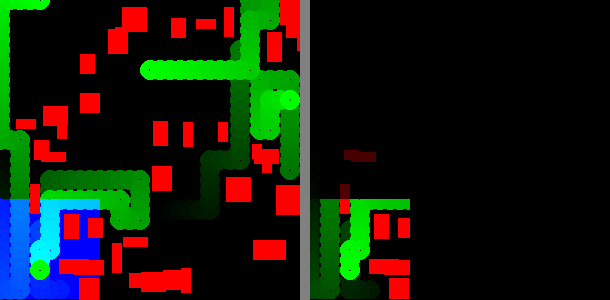

		 Coverage 			 Drone Coverage 


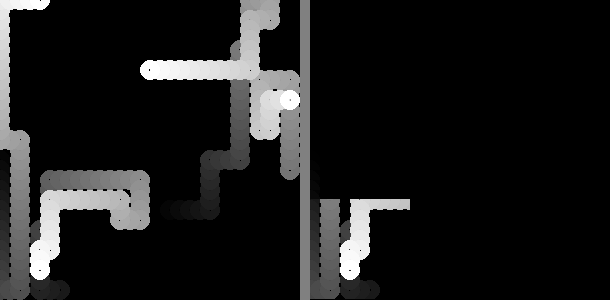

KeyboardInterrupt: ignored

In [ ]:
for i in range(300):
    observation, reward, done, info = env.step(1)
    print(reward)
    env.render()
    time.sleep(0.1)
    

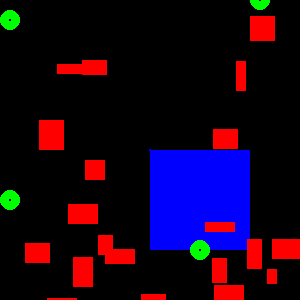

In [ ]:
env.reset()
cv2_imshow(env.env_img)

# PPO

Getting files

In [ ]:
## Get the required python files
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/PPO_agent.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/constants.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/Train.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/custom_algorithms.py

--2020-12-06 00:21:05--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5622 (5.5K) [text/plain]
Saving to: ‘actors.py.1’

actors.py.1         100%[===================>]   5.49K  --.-KB/s    in 0s      

2020-12-06 00:21:05 (65.9 MB/s) - ‘actors.py.1’ saved [5622/5622]

--2020-12-06 00:21:05--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15896 (16

In [ ]:
!pip install pygame
!pip install gym

In [ ]:
!mkdir checkpoints

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys

# set SDL to use the dummy NULL video driver, 
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
from PPO_agent import *
from pm_env import PMGridEnv

pygame 2.0.0 (SDL 2.0.12, python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
from torchsummary import summary

In [ ]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
# from env import Env
from tqdm import tqdm
import cv2
from collections import defaultdict
from time import time as t


### change name from pp_agent to PPO_agent
### chnage line 79 to use .n instead of length
from PPO_agent import PPO
from PPO_agent import Memory
from constants import CONSTANTS

CONST = CONSTANTS()

np.set_printoptions(threshold=np.inf, linewidth=1000, precision=3, suppress=True)



# env = Env()
height, width = 300, 300
robot_info = [20, 10, 10, 0, 260, 10, 200, 10, 10, 250, 200, 10]
drone_info = [150, 150, 100]
num_obstacles = 40 # number of objects
drone_latency = 2

env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

memory = Memory(CONST.NUM_AGENTS)
rlAgent = PPO(env)

Log Dir: tf_log/demo_CNN20


### PPO Training

In [ ]:

NUM_EPISODES = 30000
LEN_EPISODES = 1000
UPDATE_TIMESTEP = 500# 1000
curState = []
newState = []
reward_history = []
agent_history_dict = defaultdict(list)
totalViewed = []
dispFlag = False

# curRawState = env.reset()
# curState = rlAgent.formatInput(curRawState)
# rlAgent.summaryWriter_showNetwork(curState[0])

keyPress = 0
timestep = 0
loss = None


In [ ]:

for episode in tqdm(range(NUM_EPISODES)):
    curRawState = env.reset()

    # generate state for each agent
    # curState = rlAgent.formatInput(curRawState)
    curState = np.transpose(curRawState, (2,0,1))[np.newaxis,:,:,:]

    episodeReward = 0
    epidoseLoss = 0
    episodeNewVisited = 0
    episodePenalty = 0
    agent_episode_reward = [0] * CONST.NUM_AGENTS

    for step in range(LEN_EPISODES):
        timestep += 1

        # render environment after taking a step
        keyPress = 1

        # if keyPress == 1:
            # env.render()

        # TODO save video
        if episode % 500 in range(10, 15) and step % 4 == 0:
            # env.save2Vid(episode, step)
            pass
        #        a = t()
        # Get agent actions
        # =============================================================================
        #         for i in range(CONST.NUM_AGENTS):
        #             action = rlAgent.policy.act(curState[i], memory,i)
        #             aActions.append(action)
        # =============================================================================
        aActions = rlAgent.policy_old.act(curState, memory, CONST.NUM_AGENTS)
        #        b = t()
        #        print("step: ", round(b-a,2))

        # do actions

        newRawState = env.step(aActions[0])
        #        newRawState  = env.step([0])
        # agent_pos_list, current_map_state, local_heatmap_list, minimap_list, local_reward_list, shared_reward, done = newRawState
        current_map_state, shared_reward, done, _ = newRawState

        if step == LEN_EPISODES - 1:
            done = True

        for agent_index in range(CONST.NUM_AGENTS):
            if CONST.isSharedReward:
                memory.rewards.append(shared_reward)
            else:
                memory.rewards.append(local_reward_list[agent_index])
            memory.is_terminals.append(done)

        # update nextState
        # newState = rlAgent.formatInput(newRawState)
        newState = np.transpose(current_map_state, (2,0,1))[np.newaxis,:,:,:]

        if timestep % UPDATE_TIMESTEP == 0:
            loss = rlAgent.update(memory)
            memory.clear_memory()
            timestep = 0

        # print('CHECK:', timestep, len(memory.states))
        # record history

        for i in range(CONST.NUM_AGENTS):
            if CONST.isSharedReward:
                agent_episode_reward[i] += shared_reward
            else:
                agent_episode_reward[i] += local_reward_list[i]
        episodeReward += shared_reward
        #        print(shared_reward, step)
        # set current state for next step
        curState = newState

        if done:
            break

    # post episode

    # Record history
    reward_history.append(episodeReward)

    for i in range(CONST.NUM_AGENTS):
        agent_history_dict[i].append((agent_episode_reward[i]))

    # You may want to plot periodically instead of after every episode
    # Otherwise, things will slow
    rlAgent.summaryWriter_addMetrics(episode, loss, reward_history, agent_history_dict, LEN_EPISODES)
    if episode % 50 == 0:
        rlAgent.saveModel("checkpoints")

    if episode % 1000 == 0:
        rlAgent.saveModel("checkpoints", True, episode)

rlAgent.saveModel("checkpoints")
env.out.release()



  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 1/30000 [00:36<302:31:25, 36.30s/it]

  0%|          | 2/30000 [01:11<300:11:12, 36.02s/it]

  0%|          | 3/30000 [01:47<298:40:26, 35.84s/it]

  0%|          | 4/30000 [02:22<297:23:49, 35.69s/it]

  0%|          | 5/30000 [02:57<296:22:39, 35.57s/it]

  0%|          | 6/30000 [03:33<295:45:07, 35.50s/it]

  0%|          | 7/30000 [04:08<295:56:06, 35.52s/it]

  0%|          | 8/30000 [04:44<295:40:09, 35.49s/it]

  0%|          | 9/30000 [05:19<294:59:45, 35.41s/it]

  0%|          | 10/30000 [05:54<294:48:23, 35.39s/it]

  0%|          | 11/30000 [06:29<294:04:59, 35.30s/it]

  0%|          | 12/30000 [07:05<294:23:52, 35.34s/it]

  0%|          | 13/30000 [07:40<294:34:47, 35.36s/it]

  0%|          | 14/30000 [08:16<295:50:32, 35.52s/it]

  0%|          | 15/30000 [08:52<296:24:20, 35.59s/it]

  0%|          | 16/30000 [09:28<297:42:34, 35.74s/it]

  0%|          | 17/30000 [10:03<296:56:55, 35.65s/it]

  0%|       

In [ ]:
timestep, len(memory.states)

In [ ]:
minibatch_sz = CONST.NUM_AGENTS * CONST.LEN_EPISODE

# Running Heuristics-based algorithms

In [ ]:
## Get the required python files
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/custom_algorithms.py

--2020-12-13 02:19:44--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6297 (6.1K) [text/plain]
Saving to: ‘actors.py’

actors.py           100%[===================>]   6.15K  --.-KB/s    in 0s      

2020-12-13 02:19:45 (92.8 MB/s) - ‘actors.py’ saved [6297/6297]

--2020-12-13 02:19:45--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17421 (17K) [

In [ ]:
!pip install pygame
!pip install gym

     |████████████████████████████████| 11.5MB 279kB/s 


In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys

# set SDL to use the dummy NULL video driver, 
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2

In [ ]:
from pm_env import PMGridEnv
from custom_algorithms import greedy_algorithm, drone_lawnmower, Player_Lawnmower

## Greedy Algorithms

In [ ]:
# Defining Environment
height, width = 300, 300 # Grid size

# For each robot (4 here) define (row, column, size) i.e. location and size
robot_info = [30, 20, 10, 30, 260, 10, 200, 20, 10, 250, 200, 10]

# For each drone (1 here), define (row, colmn, size) i.e. location and size
drone_info = [20, 50, 100]  
drone_latency = 2 # Latency fatctor for drone

num_obstacles = 40 # number of objects


env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

		 Environment 			 Drone View 


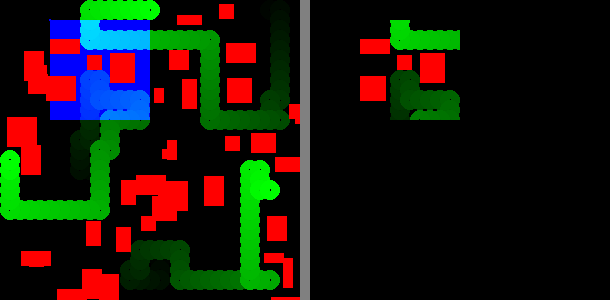

		 Coverage 			 Drone Coverage 


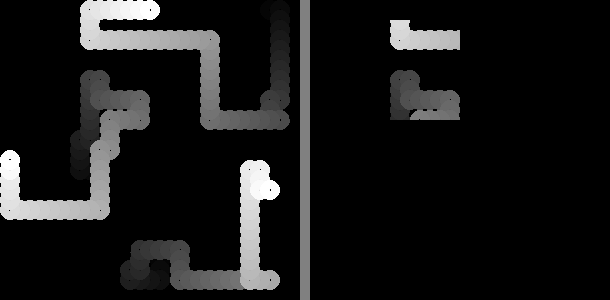

In [ ]:
for i in range(200):
    for id, player in enumerate(env.playerList):
        # Form 1: use position dircetly
        # player.pos = (x,y)

        # Form 2: use move function with size and canvas
        # player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, canvas)

        player.pos = greedy_algorithm(player, env.env_img)

    ### Not moving drone in the example
    # for drone in env.droneList:
    #     action= action_list[(start_idx + i)%num_action]
    #     drone.move(env.action_list[action], drone.step_size, env.canvas)

    ### Update graphics
    env.update_all() 

    ### Get updated coverage and observations
    # self.covergae, self.env_img = self.process_screen(my_coverage=self.coverage, my_canvas=self.canvas)
    env.process_screen()
    
    ### Get drone's view
    env.drone_map = env.get_droneview(env.drone_map, env.env_img)

    ### Show images
    env.render()

    time.sleep(0.1)

## Lawnmower Algorithms

In [ ]:
# Defining Environment
height, width = 300, 300 # Grid size

# For each robot (4 here) define (row, column, size) i.e. location and size
robot_info = [30, 20, 10, 30, 260, 10, 200, 20, 10, 250, 200, 10]

# For each drone (1 here), define (row, colmn, size) i.e. location and size
drone_info = [20, 50, 100]  
drone_latency = 2 # Latency fatctor for drone

num_obstacles = 40 # number of objects


env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

		 Environment 			 Drone View 


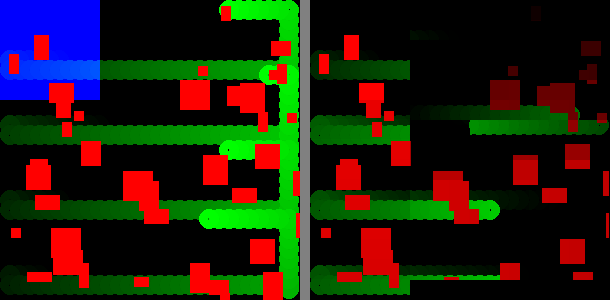

		 Coverage 			 Drone Coverage 


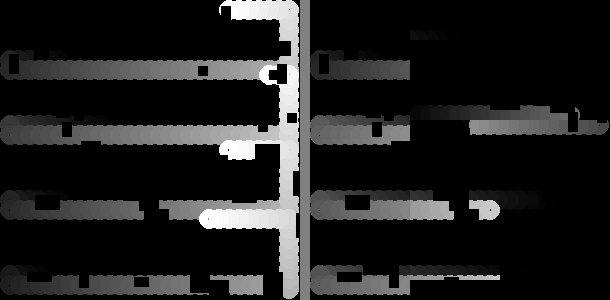

In [ ]:
### Reset position for each UGVs to work well in the Lawnmower algorithm
for id, player in enumerate(env.playerList):
    player.pos[0] = id*env.canvas.height//len(env.playerList)
    
### Get Lawnmover generators for UGVs Lawnmower algorithm
pl_lmwer = Player_Lawnmower(env.playerList, env.canvas)
gens = pl_lmwer.get_all_generators()


################################################

### Get action list for Drone Lawnmower algorithm
start_idx_d, action_list_d = drone_lawnmower(env.droneList[0], env.canvas)
num_action = len(action_list_d)

#################################################

# Running algorithms
for i in range(200):
    for id, player in enumerate(env.playerList):
        # Form 1: use position dircetly
        # player.pos = (x,y)

        # Form 2: use move function with size and canvas
        # player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, canvas)

        # Get next move based from Lawnmower
        player.move(next(gens[id]), player.size, env.canvas)
        
    ### Update drones' locations
    for drone in env.droneList:
        action= action_list_d[(start_idx_d + i)%num_action]
        drone.move(env.action_list[action], drone.step_size, env.canvas)

    ### Update graphics
    env.update_all() 

    ### Get updated coverage and observations
    # self.covergae, self.env_img = self.process_screen(my_coverage=self.coverage, my_canvas=self.canvas)
    env.process_screen()
    
    ### Get drone's view
    env.drone_map = env.get_droneview(env.drone_map, env.env_img)

    env.render()
    time.sleep(0.1)

## Information Greedy (2)

In [ ]:
from custom_algorithms import info_greedy_2

In [ ]:
# Defining Environment
height, width = 300, 300 # Grid size

# For each robot (4 here) define (row, column, size) i.e. location and size
robot_info = [30, 20, 10, 30, 260, 10, 200, 20, 10, 250, 200, 10]

# For each drone (1 here), define (row, colmn, size) i.e. location and size
drone_info = [20, 50, 100]  
drone_latency = 2 # Latency fatctor for drone

num_obstacles = 40 # number of objects


env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

### Using Environement image (perfect info)

		 Environment 			 Drone View 


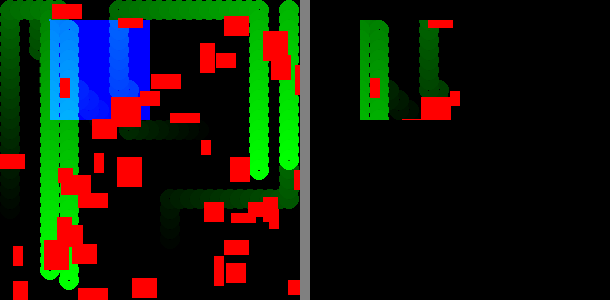

		 Coverage 			 Drone Coverage 


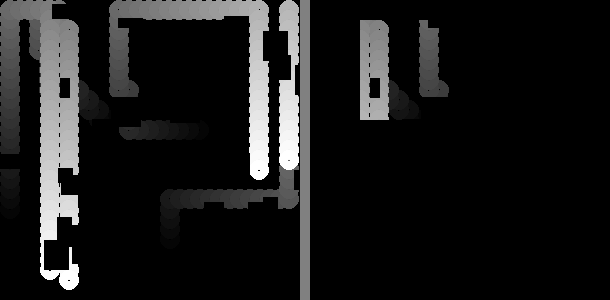

In [ ]:
for i in range(100):
    for id, player in enumerate(env.playerList):
        # Form 1: use position dircetly
        # player.pos = (x,y)

        # Form 2: use move function with size and canvas
        # player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, canvas)

        action = info_greedy_2(player, env.env_img)
        player.move(action, player.size, env.canvas)
        
    ### Not moving drone in the example
    # for drone in env.droneList:
    #     action= action_list[(start_idx + i)%num_action]
    #     drone.move(env.action_list[action], drone.step_size, env.canvas)

    ### Update graphics
    env.update_all() 

    ### Get updated coverage and observations
    # self.covergae, self.env_img = self.process_screen(my_coverage=self.coverage, my_canvas=self.canvas)
    env.process_screen()
    
    ### Get drone's view
    env.drone_map = env.get_droneview(env.drone_map, env.env_img)

    ### Show images
    env.render()

    # time.sleep(0.01)

### Using players'/robots' local info

In [ ]:
# Defining Environment
height, width = 300, 300 # Grid size

# For each robot (4 here) define (row, column, size) i.e. location and size
robot_info = [30, 20, 10, 30, 260, 10, 200, 20, 10, 250, 200, 10]

# For each drone (1 here), define (row, colmn, size) i.e. location and size
drone_info = [20, 50, 100]  
drone_latency = 2 # Latency fatctor for drone

num_obstacles = 40 # number of objects


env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

		 Environment 			 Drone View 


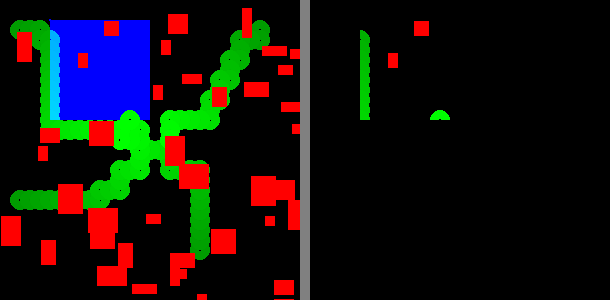

		 Coverage 			 Drone Coverage 


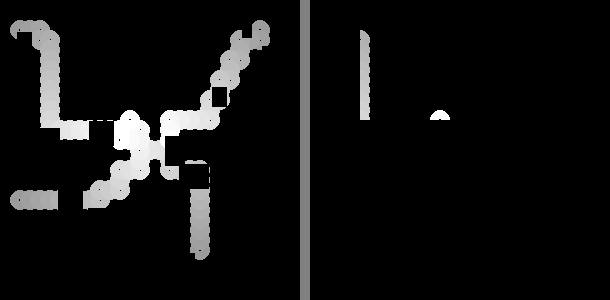

In [ ]:
for i in range(20):
    for id, player in enumerate(env.playerList):
        # Form 1: use position dircetly
        # player.pos = (x,y)

        # Form 2: use move function with size and canvas
        # player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, canvas)
    
        action = info_greedy_2(player, player.info)
        player.move(action, player.size, env.canvas)
        
    ### Not moving drone in the example
    # for drone in env.droneList:
    #     action= action_list[(start_idx + i)%num_action]
    #     drone.move(env.action_list[action], drone.step_size, env.canvas)

    ### Update graphics
    env.update_all() 

    ### Get updated coverage and observations
    # self.covergae, self.env_img = self.process_screen(my_coverage=self.coverage, my_canvas=self.canvas)
    env.process_screen()
    
    ### Get drone's view
    env.drone_map = env.get_droneview(env.drone_map, env.env_img)

    ### Show images
    env.render()

    time.sleep(0.005)

### Info Greedy motion for drone

In [ ]:
from custom_algorithms import info_greedy_drone_2

In [ ]:
# Defining Environment
height, width = 300, 300 # Grid size

# For each robot (4 here) define (row, column, size) i.e. location and size
robot_info = [30, 20, 10, 30, 260, 10, 200, 20, 10, 250, 200, 10]

# For each drone (1 here), define (row, colmn, size) i.e. location and size
drone_info = [20, 50, 100]  
drone_latency = 2 # Latency fatctor for drone

num_obstacles = 40 # number of objects


env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

		 Environment 			 Drone View 


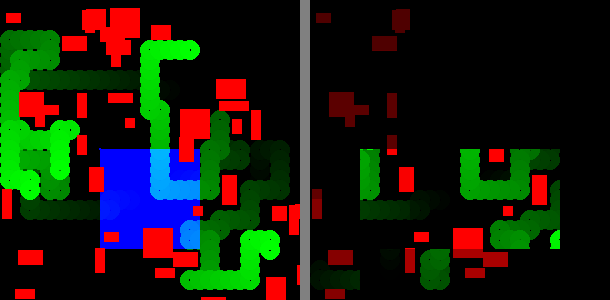

		 Coverage 			 Drone Coverage 


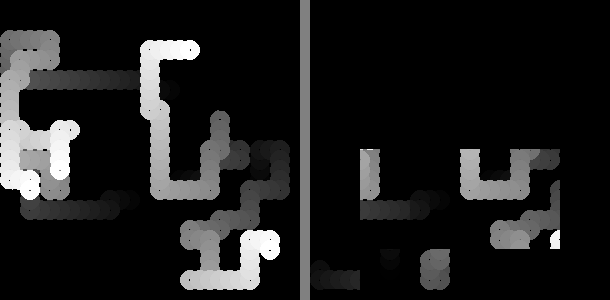

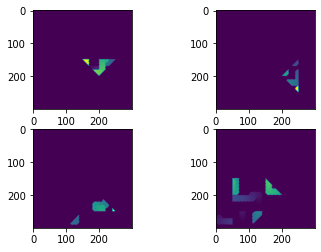

In [ ]:
for i in range(100):
    for id, player in enumerate(env.playerList):
        # Form 1: use position dircetly
        # player.pos = (x,y)

        # Form 2: use move function with size and canvas
        # player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, canvas)

        player.pos = greedy_algorithm(player, env.env_img)
        
        
    for drone in env.droneList:
        action = info_greedy_drone_2(drone, env.drone_map)
        drone.move(action, drone.size//2, env.canvas)

    ### Update graphics
    env.update_all() 

    ### Get updated coverage and observations
    # self.covergae, self.env_img = self.process_screen(my_coverage=self.coverage, my_canvas=self.canvas)
    env.process_screen()
    
    ### Get drone's view
    env.drone_map = env.get_droneview(env.drone_map, env.env_img)

    ### Show images
    env.render()

    time.sleep(0.005)

# Planning using Latency-based Particle Filter (L-PF)

In [ ]:
## Get the required python files
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/custom_algorithms.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/particle_filter.py

--2020-12-24 14:27:23--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6391 (6.2K) [text/plain]
Saving to: ‘actors.py’

actors.py           100%[===================>]   6.24K  --.-KB/s    in 0s      

2020-12-24 14:27:24 (86.9 MB/s) - ‘actors.py’ saved [6391/6391]

--2020-12-24 14:27:24--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17421 (17K) [

In [ ]:
!pip install pygame
!pip install gym

     |████████████████████████████████| 11.8MB 17.0MB/s 


In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys

# set SDL to use the dummy NULL video driver, 
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2

In [ ]:
from pm_env import PMGridEnv
from custom_algorithms import info_greddy_PF
from particle_filter import *

pygame 2.0.1 (SDL 2.0.14, Python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Heuristic-based Algorithm

In [ ]:
# Defining Environment
height, width = 100, 100 # Grid size

# For each robot (4 here) define (row, column, size) i.e. location and size
robot_info = np.array([30, 20, 10, 30, 260, 10, 200, 20, 10, 250, 200, 10])//3

# For each drone (1 here), define (row, colmn, size) i.e. location and size
#drone_info = [20, 50, 100]  
# drone_info = [40, 20, 100]  
drone_info = [10,20, 30]# np.array([40, 20, 100] )
drone_latency = 2 # Latency fatctor for drone

num_obstacles = 40 # number of objects

env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

num_agents= len(env.playerList)



#initialize belief space
env.belief= np.zeros((height, width))
env.num_beliefs= 30
init_belief(env)

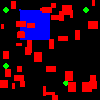

In [ ]:
cv2_imshow(env.env_img)

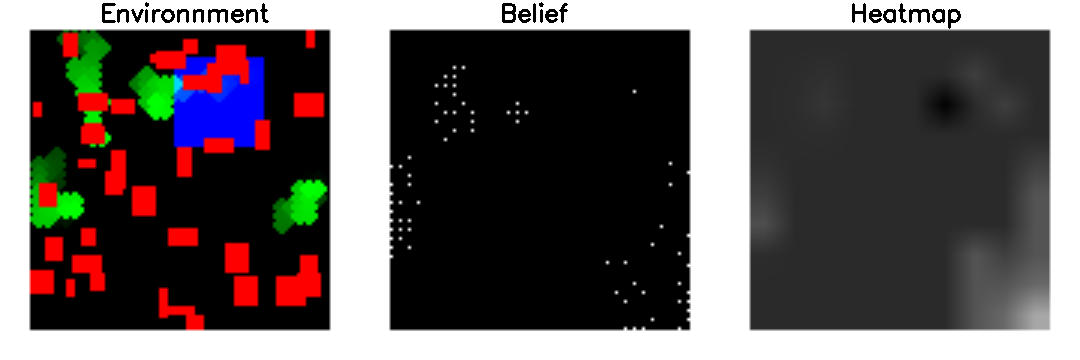

In [ ]:
# Initialize heatmap
heatmap = discretize_env(env, grid_size = 10)

for i in range(200):
    for id, player in enumerate(env.playerList):
        # Form 1: use position dircetly
        # player.pos = (x,y)

        # Form 2: use move function with size and canvas
        player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, env.canvas)

        # Get next move based from Lawnmower
        # player.move(next(gens[id]), player.size, env.canvas)
        
        
    ### Update drones' locations
    for drone in env.droneList:
        action = info_greddy_PF(drone, heatmap, env.action_list)
        drone.move(action, drone.size//5, env.canvas)

    ### Update graphics
    env.update_all() 

    ### Get updated coverage and observations
    # self.covergae, self.env_img = self.process_screen(my_coverage=self.coverage, my_canvas=self.canvas)
    env.process_screen()

    ### Get drone's view
    env.drone_map = env.get_droneview(env.drone_map, env.env_img)

    ### Generate Heatmap of size 10x10
    heatmap = discretize_env(env, grid_size = 10)

    ### Get drone's belife space
    env.belief= update_belief(env.belief,env)
    


    ################# Visualization #####################3
    ### Add borders to the environment image
    new_img1 = cv2.copyMakeBorder(env.env_img,10,10,10,10,cv2.BORDER_CONSTANT,value=(255,255,255))
    
    ### Get particles/belief image (as RGB) and add borders
    particles_img = np.array([env.belief]*3).transpose(1,2,0).astype(np.uint8)
    new_img2 = cv2.copyMakeBorder(particles_img,10,10,10,10,cv2.BORDER_CONSTANT,value=(255,255,255))
    
    ### Convert heatmap to a RGB image and add order
    heatmap_img = np.array([cv2.resize(heatmap, (height, width))]*3).transpose(1,2,0)
    heatmap_img = (255*((heatmap_img+100)/600.)).astype(np.uint8)
    new_img3 = cv2.copyMakeBorder(heatmap_img,10,10,10,10,cv2.BORDER_CONSTANT,value=(255,255,255))
    
    ### Combine images
    final_img = np.hstack([new_img1, new_img2, new_img3])
    final_img = cv2.resize(final_img, (final_img.shape[1]*3, final_img.shape[0]*3))

    ### Add labels
    final_img = cv2.putText(final_img, 'Environnment', (100, 21), fontFace = cv2.FONT_HERSHEY_SIMPLEX , fontScale=0.8, color=(0,0,0), thickness= 2)
    final_img = cv2.putText(final_img, 'Belief', (500, 21), fontFace = cv2.FONT_HERSHEY_SIMPLEX , fontScale=0.8, color=(0,0,0), thickness= 2)
    final_img = cv2.putText(final_img, 'Heatmap', (850, 21), fontFace = cv2.FONT_HERSHEY_SIMPLEX , fontScale=0.8, color=(0,0,0), thickness= 2)


    
    output.clear()
    cv2_imshow(final_img)
    time.sleep(0.5)


## RL-based Algo

In [ ]:
## Get the required additional python files
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/PPO_agent.py
!wget https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/constants.py

--2020-12-24 16:13:47--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/actors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6391 (6.2K) [text/plain]
Saving to: ‘actors.py.2’

actors.py.2         100%[===================>]   6.24K  --.-KB/s    in 0s      

2020-12-24 16:13:47 (105 MB/s) - ‘actors.py.2’ saved [6391/6391]

--2020-12-24 16:13:47--  https://raw.githubusercontent.com/kulbir-ahluwalia/CMSC818B_MiniProject_2/main/python/pm_env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17551 (17K

In [2]:
!mkdir rl_models/ 
!wget https://umd.box.com/shared/static/lqq38ea82er4dpxqpl3fcv2pdlffc0qe.pt -O rl_models/pmrl_particle_30_eplen_1000_itrs_30000_batch_1000.pt
!wget https://umd.box.com/shared/static/prybpeyvru3amliydtisoxk1kgvmfsm6.pt -O rl_models/pmrl_particle_10_eplen_500_itrs_15000_batch_2000.pt
!wget https://umd.box.com/shared/static/f4w4ffhvoi4k454l02hfq9jwhfaildm9.pt -O rl_models/pmrl_particle_30_eplen_500_itrs_15000_batch_1000.pt


mkdir: cannot create directory ‘rl_models/’: File exists
--2020-12-24 17:29:19--  https://umd.box.com/shared/static/lqq38ea82er4dpxqpl3fcv2pdlffc0qe.pt
Resolving umd.box.com (umd.box.com)... 107.152.26.197
Connecting to umd.box.com (umd.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/lqq38ea82er4dpxqpl3fcv2pdlffc0qe.pt [following]
--2020-12-24 17:29:19--  https://umd.box.com/public/static/lqq38ea82er4dpxqpl3fcv2pdlffc0qe.pt
Reusing existing connection to umd.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://umd.app.box.com/public/static/lqq38ea82er4dpxqpl3fcv2pdlffc0qe.pt [following]
--2020-12-24 17:29:19--  https://umd.app.box.com/public/static/lqq38ea82er4dpxqpl3fcv2pdlffc0qe.pt
Resolving umd.app.box.com (umd.app.box.com)... 107.152.26.201
Connecting to umd.app.box.com (umd.app.box.com)|107.152.26.201|:443... connected.
HTTP request sent, awaiting response... 3

In [ ]:
from PPO_agent import *

In [ ]:
# Defining Environment
height, width = 100, 100 # Grid size

# For each robot (4 here) define (row, column, size) i.e. location and size
robot_info = np.array([30, 20, 10, 30, 260, 10, 200, 20, 10, 250, 200, 10])//3

# For each drone (1 here), define (row, colmn, size) i.e. location and size
#drone_info = [20, 50, 100]  
# drone_info = [40, 20, 100]  
drone_info = [10,20, 30]# np.array([40, 20, 100] )
drone_latency = 2 # Latency fatctor for drone

num_obstacles = 40 # number of objects

env = PMGridEnv(height, width, robot_info, drone_info, num_obstacles, drone_latency)

num_agents= len(env.playerList)



#initialize belief space
env.belief= np.zeros((height, width))
env.num_beliefs= 10
init_belief(env)

In [ ]:
memory = Memory(CONST.NUM_AGENTS)
rlAgent = PPO(env)
rlAgent.loadModel("rl_models/ActorCritic_30part_500itr.pt", 1)

Log Dir: tf_log/demo_CNN888


Reward: 63


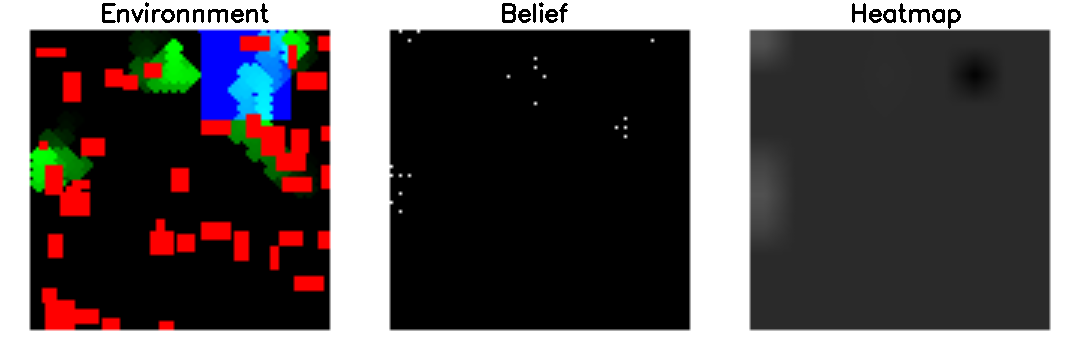

In [ ]:
# Initialize heatmap
heatmap = discretize_env(env, grid_size = 10)
        
for i in range(200):
    for id, player in enumerate(env.playerList):
        # Form 1: use position dircetly
        # player.pos = (x,y)

        # Form 2: use move function with size and canvas
        player.move(np.random.choice(['up', 'down', 'left', 'right']), player.size, env.canvas)

        # Get next move based from Lawnmower
        # player.move(next(gens[id]), player.size, env.canvas)
        
        
    ### Update drones' locations
    for drone in env.droneList:
        action = info_greddy_PF(drone, heatmap, env.action_list)
        drone.move(action, drone.size//5, env.canvas)

    ### Update graphics
    env.update_all() 

    ### Get updated coverage and observations
    # self.covergae, self.env_img = self.process_screen(my_coverage=self.coverage, my_canvas=self.canvas)
    env.process_screen()

    ### Get drone's view
    env.drone_map = env.get_droneview(env.drone_map, env.env_img)

    ### Get reward
    rwd = reward(env)
    
    ### Generate Heatmap of size 10x10
    heatmap = discretize_env(env, grid_size = 10)

    ### Get drone's belife space
    env.belief= update_belief(env.belief,env)
    


    ################# Visualization #####################3
    ### Add borders to the environment image
    new_img1 = cv2.copyMakeBorder(env.env_img,10,10,10,10,cv2.BORDER_CONSTANT,value=(255,255,255))
    
    ### Get particles/belief image (as RGB) and add borders
    particles_img = np.array([env.belief]*3).transpose(1,2,0).astype(np.uint8)
    new_img2 = cv2.copyMakeBorder(particles_img,10,10,10,10,cv2.BORDER_CONSTANT,value=(255,255,255))
    
    ### Convert heatmap to a RGB image and add order
    heatmap_img = np.array([cv2.resize(heatmap, (height, width))]*3).transpose(1,2,0)
    heatmap_img = (255*((heatmap_img+100)/600.)).astype(np.uint8)
    new_img3 = cv2.copyMakeBorder(heatmap_img,10,10,10,10,cv2.BORDER_CONSTANT,value=(255,255,255))
    
    ### Combine images
    final_img = np.hstack([new_img1, new_img2, new_img3])
    final_img = cv2.resize(final_img, (final_img.shape[1]*3, final_img.shape[0]*3))

    ### Add labels
    final_img = cv2.putText(final_img, 'Environnment', (100, 21), fontFace = cv2.FONT_HERSHEY_SIMPLEX , fontScale=0.8, color=(0,0,0), thickness= 2)
    final_img = cv2.putText(final_img, 'Belief', (500, 21), fontFace = cv2.FONT_HERSHEY_SIMPLEX , fontScale=0.8, color=(0,0,0), thickness= 2)
    final_img = cv2.putText(final_img, 'Heatmap', (850, 21), fontFace = cv2.FONT_HERSHEY_SIMPLEX , fontScale=0.8, color=(0,0,0), thickness= 2)


    
    output.clear()
    print(f'Reward: {rwd}')
    cv2_imshow(final_img)
    time.sleep(0.5)
